# Assignment 2: Naive Bayes, Text Classification and Log-Sum-Exp-Trick

Only use the already imported library `numpy`. Make sure that the `liar.txt` dataset is in the same directory as the notebook.

List your team members (name and immatriculation number) in the following cell:

- *Your names here*

In [1]:
# Load required packages and dataset. Do not modify.
import numpy as np


def load_liar_dataset():
    import string
    
    with open('liar.txt', mode='r', encoding='utf-8') as f:
        rows = [l.strip().split('\t')[:2] for l in f]
    
    y, X = zip(*rows)
    X =[x.translate(str.maketrans('', '', string.punctuation)).lower().split() for x in X]
    
    return X, y
    

X, y = load_liar_dataset()

print('Sample:')
print(f'{y[0]}: {X[0]}')
print(f'{y[2]}: {X[2]}')

Sample:
real: ['thanks', 'to', 'our', 'reforms', 'the', 'average', 'family', 'will', 'have', 'an', 'extra', '322', 'to', 'spend']
real: ['winning', 'enough', 'pledged', 'delegates', 'is', 'not', 'impossible']


### Task 2: Fake News Classification with Naive Bayes

Implement a Naive Bayes classifier with Laplace smoothing to detect whether a text message is fake or real (not fake).

A text message is represented by a list of string tokens as shown above.
The classification target is binary and the two possible labels are the strings `'fake'` and `'real'`.

Fill out the methods in `NaiveBayesFakeNewsClassifier` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed.

Hint: Try to map the text messages to word frequency vectors by counting how often each word occurs in a message.

In [2]:
from collections import Counter, defaultdict
from math import log

# Implement your solution here.
class NaiveBayesFakeNewsClassifier(object):
    def __init__(self):
        self.total_docs = None
        self.classes = None
        self.docs_per_class = None
        self.vocabulary = set()
        self.vocabulary_size = None
        self.collection_frequency = {
            'real': Counter(),
            'fake': Counter()
        }
    
    def fit(self, X, y):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        y is a list of `n` labels either the string 'Fake' or the string 'real'.
        """
        for sample, label in zip(X, y):
            self.collection_frequency[label].update(sample)
            self.vocabulary.update(sample)
        
        self.vocabulary_size = len(self.vocabulary)
    
    def predict(self, X):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        The method returns a list of `n` strings, i.e. classification labels ('fake' or 'real').
        """
        result = []
        
        for sample in X:
            real_prob, fake_prob = 0.5, 0.5 # Prior
            for word in sample:
                cnt_real = self.collection_frequency['real'][word]
                cnt_fake = self.collection_frequency['fake'][word]
                
                real_prob *= self.likelihood(cnt_real, 'real')
                fake_prob *= self.likelihood(cnt_fake, 'fake')
                
            result.append('real' if real_prob > fake_prob else 'fake')
                
        return result
    
    def likelihood(self, freq, label):
        agg = 0
        for _, val in self.collection_frequency[label].items():
            agg += 1

        return (freq + 1) / (agg + self.vocabulary_size)
        

/tmp/ipykernel_78257/3161370410.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'real', 'fake'])
/tmp/ipykernel_78257/3161370410.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'real', 'fake'])


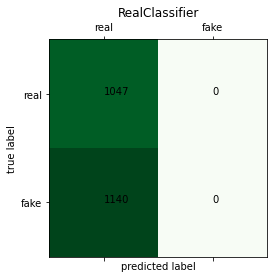

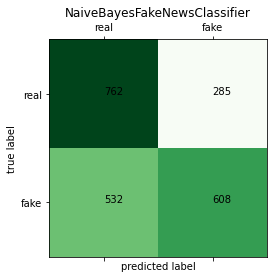

In [3]:
# The following code will evaluate your classifier.
class RealClassifier(object):
    """
    This classifier is a primitive baseline, which just predicts the most common class each time.
    Naive Bayes should definitely beat this.
    """
    def fit(self, X, y): pass
    def predict(self, X): return len(X)*['real']

    
def train_evaluate(classifier, X, y):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split
    
    # Apply train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    # Inititialize and train classifier.
    classifier.fit(X_train, y_train)
    # Evaluate classifier on test data.
    yhat_test = classifier.predict(X_test)
    cmatrix = confusion_matrix(y_test, yhat_test, labels=['real', 'fake'])
        
    return cmatrix


def plot_confusion_matrix(cmatrix, classifier_name):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1)
    ax.matshow(cmatrix, cmap='Greens')
    for x in (0, 1):
        for y in (0, 1):
            ax.text(x, y, cmatrix[y, x])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    ax.set_xticklabels(['', 'real', 'fake'])
    ax.set_yticklabels(['', 'real', 'fake'])
    ax.set_title(classifier_name)

    
real_classifier = RealClassifier()
your_classifier = NaiveBayesFakeNewsClassifier()
real_cmatrix = train_evaluate(real_classifier, X, y)
your_cmatrix = train_evaluate(your_classifier, X, y)

plot_confusion_matrix(real_cmatrix, 'RealClassifier')
plot_confusion_matrix(your_cmatrix, 'NaiveBayesFakeNewsClassifier')

### Task 3: Log Sum Exp Trick

Assume you want to apply your Bayesian classifier to a very long text. For the sake of simplicity there is only a single word $x$ and two classes $c=0$ and $c=1$. So given you have a sentence $s$ of length $n$ (only composed out of the word $x$) the probability of a class is

$$ p(c | s) = \frac{p(x | c)^{n} p(c)}{\sum_{c'}p(x | c')^{n} p(c')} $$

So the probability should converge towards $1$ with increasing $n$ for the class with the higher probability of the word $p(x|c)$. Let's implement the equation as found in the textbook and see what happens if we increase $n$.

In [4]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

def posterior(n):
    """
    Probability of a class given a sentence of length n.
    """
    word_given_class = np.asarray([0.095, 0.096])
    sentence_likelihood = np.power(word_given_class, int(n))
    prior = np.ones(2) / 2
    posterior = (sentence_likelihood * prior) / (sentence_likelihood.T @ prior)
    return posterior

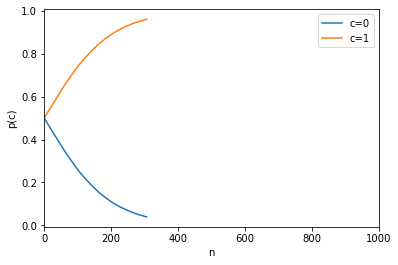

In [5]:
plt.plot(np.linspace(0,1e3,50), [posterior(n) for n in np.linspace(0, 1e3, 50)], label=['c=0', 'c=1'])
plt.xlim(0, 1e3)
plt.xlabel('n')
plt.ylabel('p(c)')
plt.legend()
plt.show()

Oh, that is not what we expected. Do you understand what happend here?

In [6]:
posterior(n=500)

array([nan, nan])

You are observing an numerical underflow, as you multiplied too many small numbers beyond the precision of floating point numbers.

A common approach is to deal with probabilities in logspace (sometimes also called logits) to make the computations more stable.

**Task**: Implement the posterior computation from above in logspace. (compare slide 39 "Implementation Details")

In [7]:
def posterior_logspace(n):
    """
    Computation of the posterior (same as above) in logspace.
    
    Hint: use np.exp() on the return value to return a valid probability instead of logits
    """
    word_given_class = np.asarray([0.095, 0.096])
    
    sentence_likelihood = np.power(word_given_class, int(n))
    log_sentence_likelihood = int(n) * np.log(word_given_class)
    
    prior = np.ones(2) / 2
    log_prior = np.log(prior)
    
    log_normalizer = np.log(np.sum(np.exp(log_sentence_likelihood + log_prior)))
    
    log_posterior = log_sentence_likelihood + log_prior - log_normalizer

    return np.exp(log_posterior)

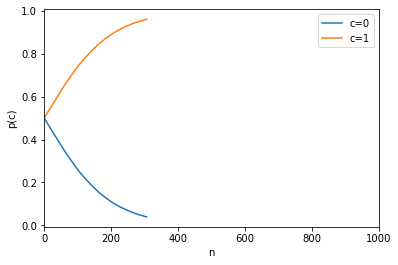

In [8]:
plt.plot(np.linspace(0,1e3,50), [posterior_logspace(n) for n in np.linspace(0, 1e3, 50)], label=['c=0', 'c=1'])
plt.xlim(0, 1e3)
plt.xlabel('n')
plt.ylabel('p(c)')
plt.legend()
plt.show()

This did not really fix the problem, right?

The problem is the expression `np.log(np.sum(np.exp(...)))` in your code, especially the sum of very small probabilities after leaving logspace with `np.exp()`. Can you improve the stability of this operation?

**Task**: Implement the same computation using the so-called log-sum-exp trick (see the hint below). 

Hint: Try to rewrite the expression by subtracting the maximum of all logits from each individual logit. What needs to be added in the end in order to not change the result of the computation?

Btw., it is forbidden to use `np.logaddexp()` in this task, since it is already implementing the trick we are looking for in this task.

In [9]:
def posterior_logsumexp_trick(n):
    """
    Task: Implement the Log-Sum-Exp-Trick
    """
    word_given_class = np.asarray([0.095, 0.096])
    
    sentence_likelihood = np.power(word_given_class, int(n))
    log_sentence_likelihood = int(n) * np.log(word_given_class)
    
    prior = np.ones(2) / 2
    log_prior = np.log(prior)
    
    mx = np.max(log_sentence_likelihood + log_prior)
    log_trick_normalizer = mx + np.log(np.sum(np.exp(log_sentence_likelihood + log_prior - mx)))
    
    log_posterior = log_sentence_likelihood + log_prior - log_trick_normalizer

    return np.exp(log_posterior)

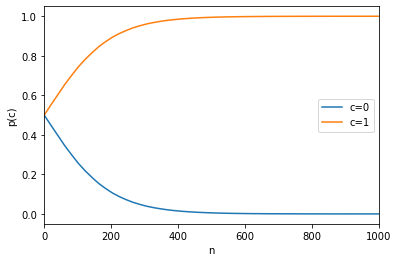

In [10]:
plt.plot(np.linspace(0,1e3,50), [posterior_logsumexp_trick(n) for n in np.linspace(0, 1e3, 50)], label=['c=0', 'c=1'])
plt.xlim(0, 1e3)
plt.xlabel('n')
plt.ylabel('p(c)')
plt.legend()
plt.show()

The resulting computation should now be stable for all $n$ within the range of the plot.